# **Rayan International AI Contest**

<font style='font-family: "Times New Roman", Times, serif; font-size: 24px;'><strong>Machine Learning & Deep Learning Course </strong></font>

<font style='font-family: "Times New Roman", Times, serif; font-size: 20px;'><em>**Homework 3** || **Title**: Variational Autoencoder</em></font>


## Import Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

## Parameter Settings


Here we define some key hyperparameters:

- **Latent Dimensions (`latent_dims = 2`)**: Allows for easy 2D visualization of the results.
- **Epochs (`num_epochs = 30`)**: The model will train for 30 iterations.
- **Batch Size (`batch_size = 128`)**: 128 samples are processed at a time.
- **Capacity (`capacity = 64`)**: Determines the model's initial complexity.
- **Learning Rate (`learning_rate = 1e-3`)**: Controls the step size during optimization.
- **Variational Beta (`variational_beta = 1`)**: Balances reconstruction and regularization.
- **Use GPU (`use_gpu = True`)**: Enables faster training with GPU support.


In [ ]:
latent_dims = 2
num_epochs = 30
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

We will use MNIST as always. Fill the required lines

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data', train=True, transform=img_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data', train=False, transform=img_transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15049600.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 454292.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3994960.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10258766.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Variational Autoencoder (VAE) Implementation

This code defines a Variational Autoencoder (VAE) using PyTorch. A VAE is a type of generative model that learns to encode input data into a latent space, then decode it back to the original data distribution.

### **Encoder Class**
The `Encoder` class maps input images into a latent space:
- **Convolutional Layers (`conv1`, `conv2`)**: Reduce the spatial dimensions of the input while increasing depth (channels) to extract features.
- **Fully Connected Layers (`fc_mu`, `fc_logvar`)**: Map the output features to the mean (`mu`) and log variance (`logvar`) of the latent space distribution.

The output of convolutional layer should be passed to 2 Fully Connected Layers. One will predict the mu and the other will predict the log variance of the given image.

These 2 values are used to sample from the space of images that will allow the decoder to produce a corresponding image.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c*2 x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) # logvar = std

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors. Ready to feed to FC layer
        # x.size(0) --> batch size
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar # each is just 2 numbers (latent_dims = 2) ([1,2], [3, 4])

### **Decoder Class**
The `Decoder` class reconstructs the input data from the latent space:
- **Fully Connected Layer (`fc`)**: Expands the latent vector back into a feature map.
- **Transpose Convolutional Layers (`conv2`, `conv1`)**: Upsample the feature maps back to the original image size.
- **Sigmoid Activation**: Applied in the last layer to produce outputs suitable for binary cross-entropy loss.

Decoder is like the opposite of the encoder. Takes in two numbers and outputs an image.

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7) # latent_dims = 2, c=64
        # For architecture of the cnn use the reverse of the one used in Encoder
        # Remeber to use Transpose Convolution instead of the regular one
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1) # out: 1 x 28 x 28

    def forward(self, x):
        # x = [7, 8]
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = torch.sigmoid(x) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x # return an 1*7*7 image in scale 0 to 1

### **VariationalAutoencoder Class**
Now it is time to define the VAE.
The `VariationalAutoencoder` class ties the encoder and decoder together:
- **Forward Pass**: Encodes the input to get `mu` and `logvar`, samples from the latent space, and decodes the sample back into an image.
- **Latent Sampling (`latent_sample`)**: Implements the reparameterization trick, allowing gradients to pass through the stochastic sampling process during training.

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        # TODO: Defin an Encoder and a Decoder instances
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick (ترفند پارامترسازی مجدد) (فضای نهان به فضای نرمال نزدیک باشد)
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

### **Loss Function (`vae_loss`)**
This part is basicly the heart of VAE. A good loss will teach the model our target which is to predict mean and variance of distribution for an input image. It should also teach the decoder to produce the result for a sample.
The VAE loss consists of two parts:
- **Reconstruction Loss**: Binary cross-entropy between the input and reconstructed images, encouraging the decoder to produce outputs close to the original inputs.
- **KL Divergence**: A regularization term that ensures the learned latent distribution is close to a standard normal distribution, aiding in generating new, diverse samples.

In [ ]:
def vae_loss(recon_x, x, mu, logvar):

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum') # 28*28 = 748
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

Now as usual we can define the VAE and import it to GPU

In [ ]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

Now we have to define the training loop. Use what you have learned up to this point to write the loop


In [ ]:
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader: # we do not need _ (label) for reconstruction

        # TODO: Train the model for an image_batch
        # move data to device
        image_batch = image_batch.to(device)

        # Forward pass
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # Compute loss
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] average reconstruction error: 23896.903943
Epoch [2 / 30] average reconstruction error: 21352.154386
Epoch [3 / 30] average reconstruction error: 20669.563193
Epoch [4 / 30] average reconstruction error: 20335.709634
Epoch [5 / 30] average reconstruction error: 20133.777290
Epoch [6 / 30] average reconstruction error: 19978.256511
Epoch [7 / 30] average reconstruction error: 19857.687510
Epoch [8 / 30] average reconstruction error: 19747.407710
Epoch [9 / 30] average reconstruction error: 19671.063414
Epoch [10 / 30] average reconstruction error: 19588.176475
Epoch [11 / 30] average reconstruction error: 19522.121314
Epoch [12 / 30] average reconstruction error: 19469.465231
Epoch [13 / 30] average reconstruction error: 19407.008316
Epoch [14 / 30] average reconstruction error: 19351.116182
Epoch [15 / 30] average reconstruction error: 19312.133985
Epoch [16 / 30] average reconstruction error: 19251.790495
Epoch [17 / 30] average reconstruction error: 19193.

Plot Training Curve
--------------------

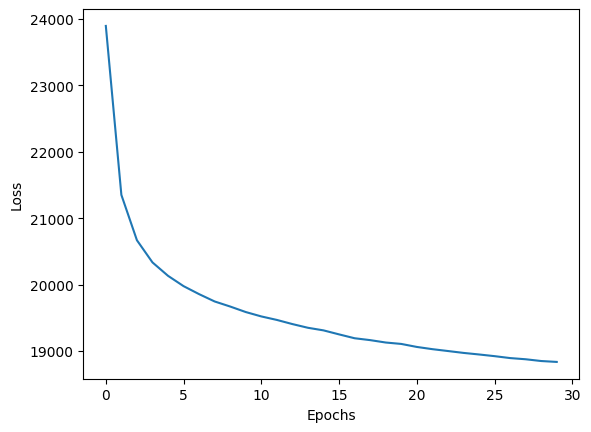

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained VAE

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 18969.010279


Visualize Reconstructions
--------------------------

Now let's test and see how similar is the output to the input image

Original images


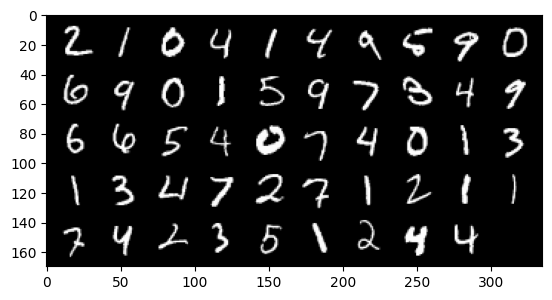

VAE reconstruction:


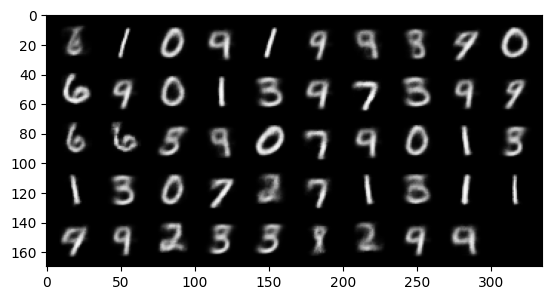

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # C*W*H --> W*H*C

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

Since the Decoder only needs a sample to create an image, it is fairly easy to produce interpolation of two image.
1. First we will provide each of the images to the Encoder.
2. After getting the `mu` for both of them we can create a sample from each image distribution without using the variances (`logvar`). Why is that?

    The reason we can use just the `mu` values for interpolation without the `logvar` is related to the purpose of interpolation and the properties of the VAE's latent space. Here's a more detailed explanation:

    - Deterministic Representation: During inference or when we want a deterministic representation of an input, we typically use only the mean (`mu`) of the latent distribution. This is because `mu` represents the most likely point in the latent space for a given input.

    - Reduced Noise: By using only `mu`, we're working with the most probable latent representation of each image, without introducing the randomness that comes from sampling using `logvar`. This leads to more stable and predictable interpolations.

    - Smooth Transitions: The goal of interpolation is to create smooth transitions between two points in the latent space. Using only `mu` ensures that we're interpolating between the most representative points for each image, leading to more meaningful and interpretable results.

    - Simplicity: For the purpose of interpolation, using just `mu` simplifies the process while still capturing the essence of the learned representations.

    - Consistent Results: Using only `mu` ensures that you get the same interpolation results each time for the same pair of images, which is often desirable for visualization and analysis purposes.

    - Training vs. Inference Difference: During training, we use both `mu` and `logvar` to sample from the distribution (reparameterization trick) to enable backpropagation and to ensure the model learns a useful latent space. However, during inference or for tasks like interpolation, we often only need the most likely latent representation, which is given by `mu`.

  It's worth noting that while using only `mu` for interpolation is common and often effective, there are scenarios where incorporating `logvar` could be beneficial:

    - If you want to capture the uncertainty in the latent space during interpolation.
    - If you're working with a model where the variance information is particularly important for the task at hand.
    - If you want to generate multiple possible interpolations between two images by sampling from the distributions defined by `mu` and `logvar`.

  In the context of the given interpolation task, using only `mu` is sufficient and provides a clear, deterministic path between the latent representations of the two images, which is typically what we want for visualization and understanding the learned latent space.

3. We will use `lambda1` to get a point between the two samples using weighted average.

In [ ]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # TODO get both mu values for each image and use the mu itself as a sample of latent space
        mu1, _ = model.encoder(img1.to(device))
        mu2, _ = model.encoder(img2.to(device))

        # interpolation of the two latent vectors
        # TODO: write a weighted average based on lambda in (0,1) for our two latents. Name the output "inter_latent"
        inter_latent = lambda1 * mu1 + (1 - lambda1) * mu2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

Having the `interpolation` function, Now we can perform our interpolation.

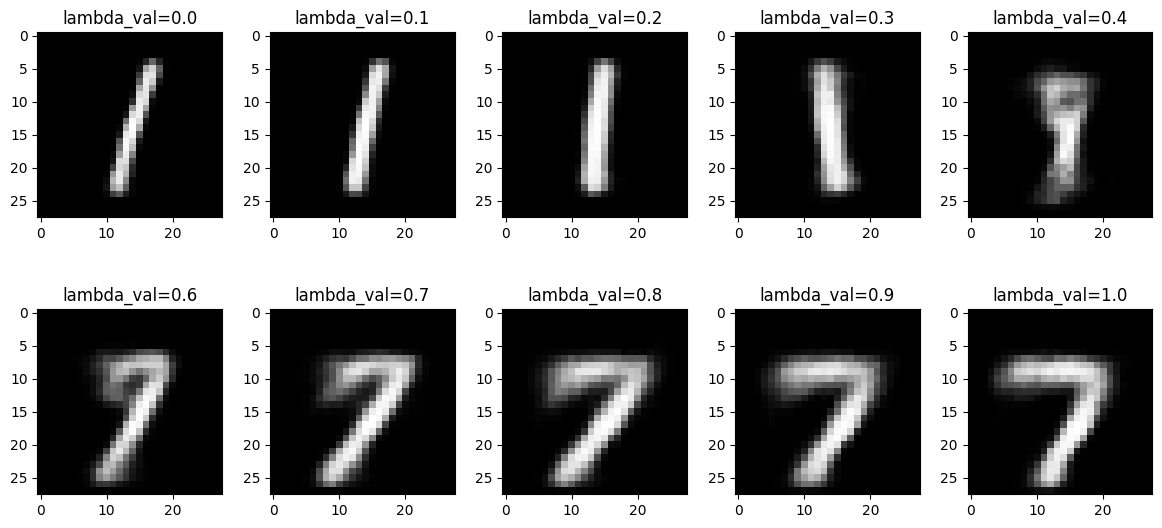

In [ ]:
vae.eval()

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range = np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image = interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val=' + str(round(l,1)))
plt.show()

Show 2D Latent Space
---------------------

Now it is time a for a really cool experiment to see how the Decoder will react to sample from any point in the latent space (The space the sampled points come from an then are feeded to the Encoder and input of Decoder)

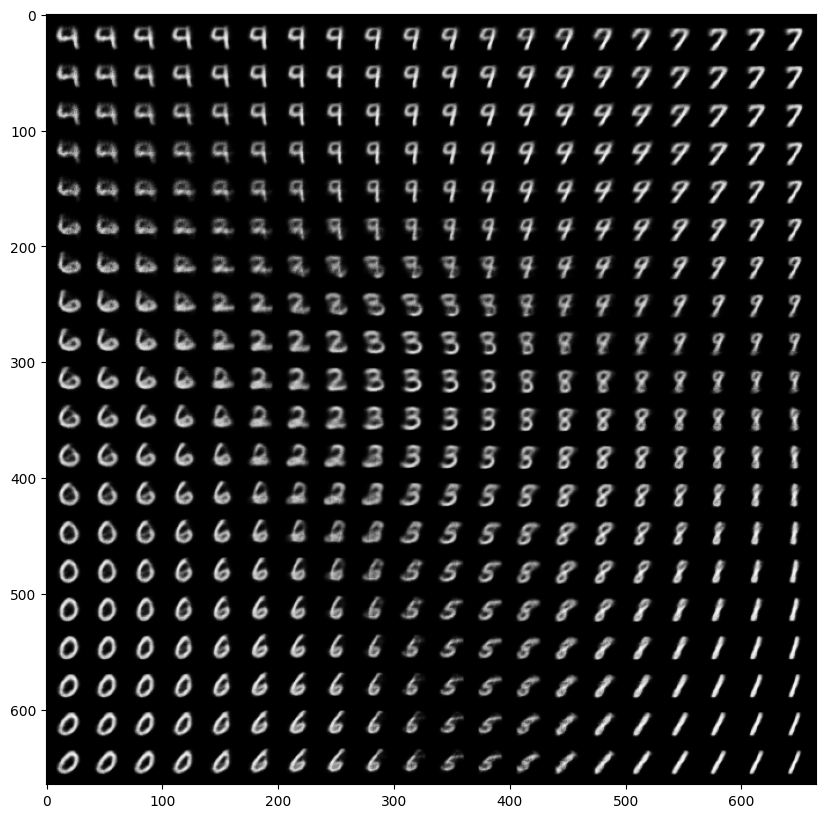

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

vae.eval()
with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20) # majority of normal distobution(mu = 0, std=1) are between (-1,+1)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents) # we just use decoder
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

The results are really good. But there is only one problem.

**Why are most of the outputs blurry?**

In a Variational Autoencoder (VAE), the outputs are often blurry due to the way the model is trained and the nature of the latent space it learns.

### Reason for Blurriness:
1. **Probabilistic Nature**: VAEs are trained to model the data distribution by learning a probabilistic latent space. The latent space is designed to follow a Gaussian distribution, which introduces some level of uncertainty. When decoding from this latent space, the model generates samples that are more like "averages" of possible outputs, leading to blurriness.

2. **Regularization vs. Reconstruction**: The VAE loss function has two main components:
   - **Reconstruction Loss**: This term encourages the model to produce outputs similar to the input images.
   - **KL Divergence**: This term regularizes the latent space to follow a standard Gaussian distribution. It prevents the model from simply memorizing the training data by spreading the latent representations across the space.
   
   The balance between these two terms is crucial. Too much emphasis on the KL divergence can force the model to produce outputs that are less sharp because it limits the complexity of the latent space, leading to more generalized (and hence blurrier) reconstructions.

3. **Latent Space Dimensionality**: If the dimensionality of the latent space is too low, the model might not have enough capacity to capture all the fine details of the input data, leading to blurrier reconstructions. However, increasing the dimensionality too much can lead to overfitting and other issues.

4. **Decoder Network**: The architecture of the decoder can also contribute to blurriness. If the decoder is not complex enough, it might not be able to generate high-resolution, sharp images from the latent representations.

### Possible Solutions:
- **Increase the capacity of the decoder**: Adding more layers or increasing the number of neurons in the decoder network might help produce sharper images.
- **Adjust the weight of the KL Divergence term**: This can be done by introducing a hyperparameter that controls the trade-off between the reconstruction loss and the KL divergence. This can allow the model to focus more on generating sharp images.
- **Use a more complex prior**: Instead of a simple Gaussian distribution, more sophisticated priors (like a mixture of Gaussians) can sometimes help in generating sharper images.

In summary, the blurriness in VAE outputs is a natural consequence of its design, balancing reconstruction accuracy with latent space regularization. The blurriness can be mitigated but is typically a trade-off with other aspects of the model’s performance.

# Stable Diffusion

Stable Diffusion is a technique used for generating high-quality images from text descriptions. It works by gradually adding noise to an image and then reversing the process to refine the image, guided by the text prompt. The model starts with random noise and iteratively denoises it, aligning the output with the input text. This approach allows for creating detailed and coherent images, making it popular for various creative applications.

You can read more about diffusion models <a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb">here</a>


## Setup & Imports

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 30 16:47:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Suc

In [ ]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [ ]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_device

## Importing Models

Stable Diffusion utilizes multiple models to operate. As it is demonstrated in the image below the process consists of multiple steps:
- The process starts with a tensor of random numbers, chosen as the initial embedding of the image.
- Simultaneously, a text prompt provided by the user is tokenized and converted into an embedding.
- Both embeddings are combined and fed into a U-Net model.
- The U-Net model goes through multiple iterations, gradually reducing the noise in the image.
- The scheduler defines the algorithm for noise reduction.
- Finally, the refined embedding is passed through the decoder of a VAE (Variational Autoencoder) to produce the output image.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>


To start, first we have to import all the required models.

In [6]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14") # symbols --> embedded numbers
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14") # Neural Net

# The UNet model for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

We will define a function to convert the latent outputs to images.

In [7]:
# space: z --> x

def latents_to_pil(latents):

    # bacth of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1) # (-1, +1) --> (0, +1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8") # float: (0, +1) --> uint: (0, 255)
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

## Prompt to Embedding


To provide the U-net model with text guidance, we need to convert text inputs to embeddings.

It's important to note that the U-net model requires a positive embedding and also a negative embedding. The code for positive embedding is provided to you. As part of the homework try writing the code for getting the negative embedding. Since we are not going to provide any negative prompt, You can use empty strings.

In [11]:
def prompt_to_emb(prompt, negative_prompt):
    # Tokenize the prompts
    batch_size = len(prompt)

    # Convert the text prompts into tokenized inputs with fixed max length
    text_inputs = tokenizer(
        prompt,
        padding="max_length", # prompt can have 77 words in maximum
        max_length=77,  # Maximum token length
        truncation=True,  # Truncate if the prompt exceeds max_length
        return_tensors="pt",  # Return as PyTorch tensors
    )
    text_input_ids = text_inputs.input_ids # text_inputs.attention_mask

    # Encode the tokenized inputs into embeddings using the text encoder
    prompt_embeds = text_encoder(text_input_ids.cuda()) # like BERT
    prompt_embeds = prompt_embeds[0]  # Extract the embeddings

    # Get the data type of the embeddings
    prompt_embeds_dtype = text_encoder.dtype

    # Ensure embeddings are in the correct dtype and on the correct device
    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    # Get the sequence length from the embeddings
    _, seq_len, _ = prompt_embeds.shape # (batch_size, 77, 768=embed_size)

    # Repeat and reshape the embeddings for further processing
    prompt_embeds = prompt_embeds.repeat(1, 1, 1)
    prompt_embeds = prompt_embeds.view(batch_size * 1, seq_len, -1)
    max_length = prompt_embeds.shape[1]
    ##############TODO################
    # TODO: Write the code for negetive prompt embedding by analysing the first half of the function
    # where the embedding of the of positive prompt was produced.

    # negative_prompt = [""] * batch_size # if we don not take negative_prompt as input

    negative_text_inputs = tokenizer(
        negative_prompt,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
    )
    negative_text_input_ids = negative_text_inputs.input_ids
    negative_prompt_embeds = text_encoder(negative_text_input_ids.cuda())[0]
    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device) # prompt_embeds_dtype = text_encoder.dtype
    negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
    negative_prompt_embeds = negative_prompt_embeds.view(batch_size * 1, seq_len, -1)

    ##################################

    # Finally Concatenate the unconditional and prompt embeddings
    concatenated_embeddings = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Return the concatenated embeddings
    return concatenated_embeddings

prompt_embeddings = prompt_to_emb(["A photo of a cat"], ["Low quality image"])
print(prompt_embeddings.shape)

torch.Size([2, 77, 768])


## Embeding to Latents

This is the part where the input Embeddings go through multiple iterations to produce the image embedding.

In [13]:
def emb_to_latents(text_embeddings):

    scheduler.set_timesteps(num_inference_steps) # num_inference_steps=50

    # Generate random latent noise for the input to the model
    latents = torch.randn((1, 4, 64, 64), dtype=torch.float32).to(torch_device)

    for t in tqdm(scheduler.timesteps):
        # Duplicate the random latent noise
        latent_model_input = torch.cat([latents] * 2)

        # Scale the model input
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings, return_dict=False, added_cond_kwargs={'text_embeds':text_embeddings} )[0]

        # Apply classifier-free guidance scale (The classifier-free guidance allows for strong text-image alignment without requiring a separate classifier model, which is a key innovation in Stable Diffusion.)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2) # unet generates two noise predictions: one based on the text prompt and one unconditional.
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond) # It combines these predictions using the guidance scale, allowing control over how much the text prompt influences the generation.

        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0] # It then uses this combined prediction to update the latent representation of the image.

    return latents

## Evaluate

Let's try the pipeline with a few examples.

  0%|          | 0/51 [00:00<?, ?it/s]

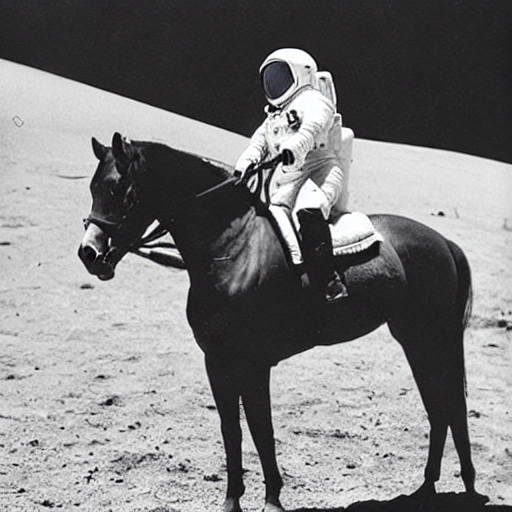

In [20]:
# prompt = ["a photograph of an astronaut riding a horse"]
# text_embeddings = prompt_to_emb(prompt)

positive_prompt = ["a photograph of an astronaut riding a horse"]
negative_prompt = ["Low quality and unreal image"]
text_embeddings = prompt_to_emb(positive_prompt, negative_prompt) # encode prompt into text_embeddings

latents = emb_to_latents(text_embeddings) # T steps unet conditioned on text_embeddings

image = latents_to_pil(latents) # VAE decoder
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

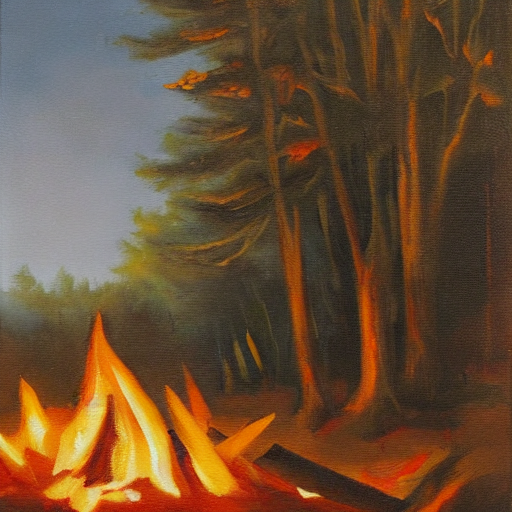

In [19]:
# prompt = ["a campfire (oil on canvas)"]
# text_embeddings = prompt_to_emb(prompt)

positive_prompt = ["a campfire (oil on canvas)"]
negative_prompt = [""]
text_embeddings = prompt_to_emb(positive_prompt, negative_prompt)

latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]